In [66]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from PIL import Image

In [94]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation',
          'No Finding']
labels.sort()
print(labels)

#read the whole dataset
df = pd.read_csv("dataset/Data_Entry_2017_v2020.csv")

print('Total entries:',len(df.index))
print('No of patients:', df["Patient ID"].nunique())
df.head()


['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total entries: 112120
No of patients: 30805


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [96]:
for label in labels:
    df[label] = df['Finding Labels'].map(lambda res: 1 if label in res else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


In [99]:
# disease per unique patient plot
positive = df[df['Infiltration']==1]
unique_pos = positive['Patient ID'].unique()
negative = df[df['Infiltration']==0]
unique_neg = negative['Patient ID'].unique()
print("Patients with Infiltration:", unique_pos.size)
print("Patients without Infiltration:", unique_neg.size)

Patients with Infiltration: 8035
Patients without Infiltration: 28801


There is imbalance towards non Infiltration patients. Note that the sum of patients with and without Infiltration is bigger than the total number of patients. This means that some patients developed infiltration along the way.

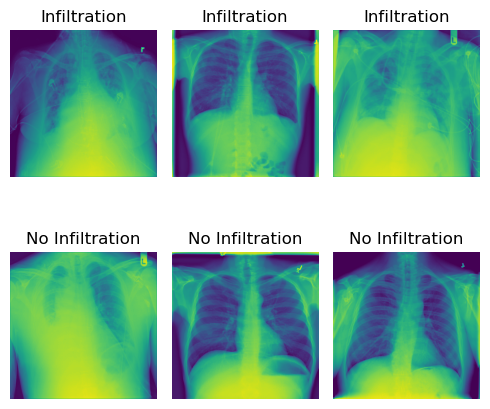

In [70]:
#Sample Infiltration and no Infiltration images:
pos_img = positive.sample(3)['Image Index'].map(lambda name: Image.open('dataset/images/'+name))
neg_img = negative.sample(3)['Image Index'].map(lambda name: Image.open('dataset/images/'+name))
axes
fig, axes = plt.subplots(2, 3, figsize=(5,5))
for img, ax in zip(pos_img, axes[0]):
    ax.imshow(img)
    ax.set_title("Infiltration")
    ax.axis('off')
for img, ax in zip(neg_img, axes[1]):
    ax.imshow(img)
    ax.set_title("No Infiltration")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [71]:
from sklearn.model_selection import GroupKFold
#Split train, val, test
groups = df[['Patient ID', 'Patient Age']]
groups.head()

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [72]:
def validate_dataset_spill(test, val, train):
    # Get the patient IDs for each set
    train_patients = set(train['Patient ID'])
    val_patients = set(val['Patient ID'])
    test_patients = set(test['Patient ID'])

    # Check if there is any overlap between the sets
    assert len(train_patients.intersection(val_patients)) == 0, "There is an overlap of patients between the training and validation sets."
    assert len(train_patients.intersection(test_patients)) == 0, "There is an overlap of patients between the training and test sets."
    assert len(val_patients.intersection(test_patients)) == 0, "There is an overlap of patients between the validation and test sets."



In [81]:
from sklearn.model_selection import GroupShuffleSplit
def group_shuffle_split(df, group_col, train_size=0.8, random_state=None):
    splitter = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)

    # Split the data into train and test sets
    train_indices, test_indices = next(splitter.split(df, groups=df[group_col]))

    # Create the train and test dataframes
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    return train_df, test_df
train_df, test_df = group_shuffle_split(df, 'Patient ID', 0.7, random_state=42)
train_df, val_df = group_shuffle_split(train_df, 'Patient ID', 0.8, random_state=42)


In [82]:
validate_dataset_spill(test_df, val_df, train_df)

In [103]:
def print_infiltraion_percentage(df, name):
    total_count = len(df)
    infiltration_count = len(df[df['Infiltration'] == 1])
    percentage = infiltration_count / total_count * 100
    print('Dataset:', name)
    print(f"Total entries: {total_count}")
    print(f"Total patients: {len(set(df['Patient ID'].values))}")
    print(f"Infiltration percentage in dataset: {percentage:.2f}%")
    print()

print_infiltraion_percentage(df, "Total")
print_infiltraion_percentage(train_df, "Train")
print_infiltraion_percentage(val_df, "Validation")
print_infiltraion_percentage(test_df,"Test")

Dataset: Total
Total entries: 112120
Total patients: 30805
Infiltration percentage in dataset: 17.74%

Dataset: Train
Total entries: 62348
Total patients: 17250
Infiltration percentage in dataset: 17.60%

Dataset: Validation
Total entries: 16218
Total patients: 4313
Infiltration percentage in dataset: 17.84%

Dataset: Test
Total entries: 33554
Total patients: 9242
Infiltration percentage in dataset: 17.96%

